# Trackster validation on electron data (1 ≤ e- ≤ 5)

## Introduction

This script validates the tracksters reconstructed by both the TICL algorithm (TICL tracksters) and our ML algorithm (model tracksters) against the caloparticles generated by the simulation. These tracksters are built from layer clusters that are produced by the CLUE2D algorithm. The following metrics are considered:
* Efficiency:

$$ \frac{\text{Total number of caloparticles that have been associated to at least one trackster}}{\text{Total number of caloparticles}} 
$$
<br>

<div style="text-align: center;">
${\scriptsize \text{A caloparticle associated to a trackster has a shared energy > 50% (of the caloparticle's raw energy after applying correction of removing one hit LCs) with the trackster.} }$  
</div>




* Purity

$$ \frac{\text{Total number of tracksters that have been associated to at least one caloparticle}}{\text{Total number of tracksters}} 
$$
<br>
<div style="text-align: center;">
${\scriptsize \text{A trackster associated to a caloparticle has a reco_to_sim score < 0.2 with it.}}$
</div>

* Number tracksters ratio:

$$ \frac{\text{Total number of tracksters}}{\text{Total number of caloparticles}}$$



## Definition of Ground Truth
* SimtrackstersCP raw data but with LCs that have noh = 1 removed.
* Perfect pattern recognition reconstructs subset of SimtrackstersCP shower that has LCs with noh > 1, since both TICL and our model was trained to reconstruct the shower partially.


## Modules to import
* model.py
* Imports.py
<br>
<br>
Data loaders:
* train.py - training data with repeats removed, noh > 1 mask applied, events with 2 <= num_cp <=5 mask applied.
* test.py - test data with repeats removed, noh > 1 mask applied.
* ground_truth.py - test data with noh > 1 mask applied.


## Code

## Section 1: Making predictions on test data with ML model and calculating metrics

In [1]:
#0: imports

import uproot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from test import CCV2
from ground_truth import CCV3
from train import CCV1
from torch_geometric.data import DataLoader 
from model import Net
#from torch_geometric.nn import knn_graph

import numpy as np
import awkward as ak
import time
from Imports import Aggloremative, calculate_reco_to_sim_score_and_sharedE, calculate_sim_to_reco_score, calculate_all_event_scores

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import TransformerConv
from torch_geometric.nn.pool import knn_graph

class Net(nn.Module):
    def __init__(self, hidden_dim=64, num_layers=4, dropout=0.3, contrastive_dim=8, num_heads=4):
        """
        Initializes a graph network that uses TransformerConv layers for attention.

        Args:
            hidden_dim (int): Dimension of hidden layers.
            num_layers (int): Number of TransformerConv layers.
            dropout (float): Dropout rate.
            contrastive_dim (int): Output dimension of the final layer.
            num_heads (int): Number of attention heads in each TransformerConv.
        """
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout

        # Input encoder (assumes input features of size 8).
        self.lc_encode = nn.Sequential(
            nn.Linear(8, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU()
        )

        # Stack of TransformerConv layers.
        #
        # Set concat=False so that the output dimension remains `hidden_dim`
        # (rather than num_heads * hidden_dim). If you prefer the concatenated
        # variant, set concat=True and adjust dimensions accordingly.
        self.transformer_layers = nn.ModuleList([
            TransformerConv(
                in_channels=hidden_dim,
                out_channels=hidden_dim,
                heads=num_heads,
                dropout=dropout,
                concat=False
            )
            for _ in range(num_layers)
        ])

        # Output layer.
        self.output = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ELU(),
            nn.Dropout(p=dropout),
            nn.Linear(64, 32),
            nn.ELU(),
            nn.Dropout(p=dropout),
            nn.Linear(32, contrastive_dim)
        )

    def forward(self, x, edge_index, batch=None):
        """
        Forward pass of the TransformerConv-based graph network.

        Args:
            x (torch.Tensor): Input node features of shape (N, 8).
            edge_index (torch.Tensor): Edge indices of shape (2, E).
            batch (torch.Tensor, optional): Batch vector for nodes.

        Returns:
            tuple: (Output features, Batch vector)
        """
        # Encode input features to hidden_dim.
        x_enc = self.lc_encode(x)  # (N, hidden_dim)

        # Pass through each TransformerConv layer.
        for conv in self.transformer_layers:
            x_enc = conv(x_enc, edge_index)
            # You can add optional residual connections, normalization, or
            # other operations here if desired:
            x_enc = F.elu(x_enc)
            x_enc = F.dropout(x_enc, p=self.dropout, training=self.training)

        # Final output transformation.
        out = self.output(x_enc)
        return out, batch


In [6]:
model = Net(128,3, dropout=0.3, contrastive_dim=16, num_heads=4)
#checkpoint= torch.load('/vols/cms/er421/hgcal/code/code/Fraction/results/epoch-21.pt',  map_location=torch.device('cpu'))
checkpoint= torch.load('/vols/cms/mm1221/hgcal/Mixed/LC/Full/runs/Trans/hd128nl3cd16nh4k32/best_model.pt',  map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)  
model.eval()  

Net(
  (lc_encode): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
  )
  (transformer_layers): ModuleList(
    (0-2): 3 x TransformerConv(128, 128, heads=4)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
  )
)

In [7]:
#1: Load Data + Model
#1.1: Load GT and trackster Data

testpath = "/vols/cms/mm1221/Data/mix/test/"
data_GT = CCV3(testpath, max_events=200)
print(len(data_GT))
gt_loader = DataLoader(data_GT, batch_size=1, shuffle=False, follow_batch=['x'])

GT_ind = data_GT.stsCP_vertices_indexes
GT_mult = data_GT.stsCP_vertices_multiplicity
GT_bc_x = data_GT.stsCP_barycenter_x
GT_regressed_energy = data_GT.stsCP_regressed_energy
energies = data_GT.stsCP_vertices_energy

Track_ind = data_GT.ts_vertices_indexes
Track_mult = data_GT.ts_vertices_multiplicity


#1.2: Load Model



### Loading data


  0%|                                                                                                                                                             | 0/1 [00:28<?, ?it/s]

Reached 200!
300



/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [8]:
#2: Generate cosine similarity plots

import torch.nn.functional as F

train_path = "/vols/cms/mm1221/Data/mix/train/"  
data_train = CCV1(train_path, max_events=99)
train_loader = DataLoader(data_train, batch_size=1, shuffle=False, follow_batch=['x','lc_ne'])

### Loading data


  0%|                                                                                                                                                             | 0/3 [00:37<?, ?it/s]

Reached 99!


In [9]:
#2.1: Load training Data

CP_x = data_train.stsCP_vertices_x
CP_y = data_train.stsCP_vertices_y
CP_z = data_train.stsCP_vertices_z
CP_ind = data_train.stsCP_vertices_indexes
CP_energy = data_train.stsCP_vertices_energy

# preceding 't' for train
tTrack_x = data_train.ts_vertices_x
tTrack_y = data_train.ts_vertices_y
tTrack_z = data_train.ts_vertices_z
tTrack_ind = data_train.ts_vertices_indexes
tTrack_energy = data_train.ts_vertices_energy 

tenergies = data_train.all_vertices_energy
tlayerid = data_train.all_vertices_layer_id
tnoh = data_train.all_vertices_noh
teta = data_train.all_vertices_eta
tphi = data_train.all_vertices_phi
t_x = data_train.all_vertices_x
t_y = data_train.all_vertices_y
t_z = data_train.all_vertices_z
ttime = data_train.all_vertices_time
ttype = data_train.all_vertices_type

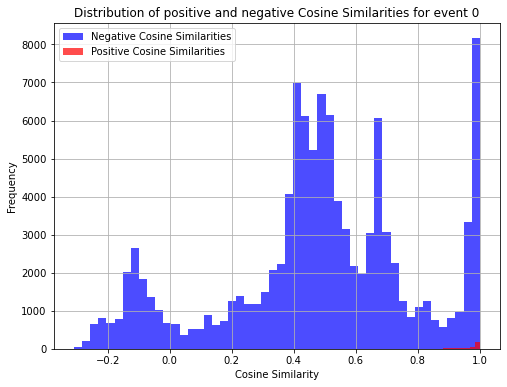

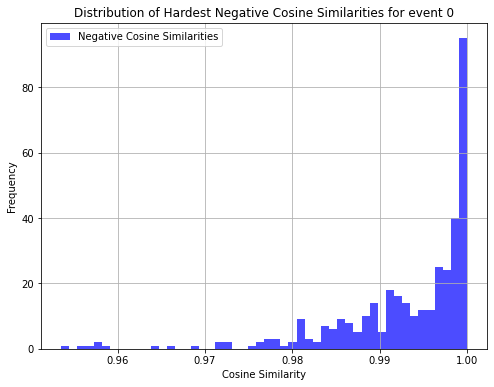

In [12]:
#2.2: Forward pass and plot cosine similarities

for data in train_loader:
    edge_index = knn_graph(data.x[:, :3], k=32, batch=data.x_batch)
    out = model(data.x, edge_index, data.x_batch)
    values_edges, counts_edges = np.unique(data.lc_ne_batch.detach().cpu().numpy(), return_counts=True)
    values, counts = np.unique(data.x_batch.detach().cpu().numpy(), return_counts=True)
    losses = []
    for e in range(len(counts)):
        lower_edge_e = 0 if e == 0 else np.sum(counts_edges[:e])
        upper_edge_e = lower_edge_e + counts_edges[e]

        lower_edge_o = 0 if e == 0 else np.sum(counts[:e]) 
        upper_edge_o = lower_edge_o + counts[e]
        
        start_pos = out[0][lower_edge_o:upper_edge_o][data.x_pe[lower_edge_o:upper_edge_o, 0]]
        end_pos = out[0][lower_edge_o:upper_edge_o][data.x_pe[lower_edge_o:upper_edge_o, 1]]
        start_neg = out[0][lower_edge_o:upper_edge_o][data.x_ne[lower_edge_e:upper_edge_e, 0]]
        end_neg = out[0][lower_edge_o:upper_edge_o][data.x_ne[lower_edge_e:upper_edge_e, 1]]
        lc_ne = data.lc_ne[lower_edge_e:upper_edge_e]
        neg_edge_indices = data.x_ne[lower_edge_e:upper_edge_e]
        break
    break
 
        
def compute_cosine_similarity(start_pos, end_pos, start_neg, end_neg, neg_edge_indices, lc_ne, temperature=0.05):
    xdevice = start_pos.get_device()
    z_start_pos = F.normalize(start_pos, dim=1)
    z_end_pos = F.normalize(end_pos, dim=1)
    z_start_neg = F.normalize(start_neg, dim=1)
    z_end_neg = F.normalize(end_neg, dim=1)
    positives = torch.exp(F.cosine_similarity(z_start_pos,z_end_pos))
    positives_similarities = F.cosine_similarity(z_start_pos,z_end_pos)
    
    # generate hard negatives
    values, counts = np.unique(lc_ne, return_counts=True)
    hard_neg_similarity = []
    hard_neg_edge_indices = []
    all_neg_similarities = []
    
    i=0
    for lc in range(0,len(counts)):
        lower_edge = 0 if lc == 0 else np.sum(counts[:lc])
        upper_edge = lower_edge + counts[lc]
        negatives_lc = F.cosine_similarity(z_start_neg[lower_edge:upper_edge],z_end_neg[lower_edge:upper_edge])
        neg_edge_indices_lc = neg_edge_indices[lower_edge:upper_edge]
        
        hard_neg_edge_idx = torch.argmax(negatives_lc)
        hard_neg_similarity.append(negatives_lc[hard_neg_edge_idx].detach().cpu().numpy())
        hard_neg_edge_indices.append(neg_edge_indices_lc[hard_neg_edge_idx])
        #print(neg_edge_indices_lc[hard_neg_edge_idx][0].detach().cpu().numpy() == lc) # should be true every time!

        all_neg_similarities.extend(negatives_lc.detach().cpu().numpy())  # Convert to numpy for easier plotting

    plt.figure(figsize=(8, 6))    
    plt.hist(all_neg_similarities, bins=50, color='blue', alpha=0.7, label='Negative Cosine Similarities')
    plt.hist(positives_similarities.detach().cpu().numpy(), bins=50, color='red', alpha=0.7, label='Positive Cosine Similarities')
    plt.title('Distribution of positive and negative Cosine Similarities for event 0')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(8, 6))
    plt.hist(hard_neg_similarity, bins=50, color='blue', alpha=0.7, label='Negative Cosine Similarities')
    plt.title('Distribution of Hardest Negative Cosine Similarities for event 0')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

loss = compute_cosine_similarity(start_pos, end_pos, start_neg, end_neg, neg_edge_indices, lc_ne, temperature=0.1)

In [4]:

# Load test data
data_test = CCV2(testpath, max_events=200)
test_loader = DataLoader(data_test, batch_size=1, shuffle=False, follow_batch=['x'])

### Loading data


  0%|                                                                                                                                                                                 | 0/1 [00:22<?, ?it/s]

Reached 200!


In [5]:
import time
import numpy as np
from sklearn.metrics.pairwise import cosine_distances  # for cosine distance calculation

all_predictions = []  
start_time = time.time()

# Get predictions for each event
for i, data in enumerate(test_loader):
    predictions = model(data.x, data.x_batch)
    all_predictions.append(predictions[0].detach().cpu().numpy())  

all_predictions = np.array(all_predictions)

# 3.2: Cluster using threshold found in Script A
all_cluster_labels = Aggloremative(all_predictions, threshold=0.2)

end_time = time.time()

# 3.3: Calculate average inference time
time_diff = end_time - start_time
inference_time = time_diff / len(all_cluster_labels)
print("average inference time:", inference_time)



average inference time: 0.05838001251220703


In [17]:
import time
import numpy as np
from sklearn.metrics.pairwise import cosine_distances  # for cosine distance calculation

# 1. Get predictions for each event
all_predictions = []  
start_time = time.time()

for i, data in enumerate(test_loader):
    predictions = model(data.x, data.x_batch)
    all_predictions.append(predictions[0].detach().cpu().numpy())  

all_predictions = np.array(all_predictions)

# 2. Cluster using threshold found in Script A (assumed to be defined)
all_cluster_labels = Aggloremative(all_predictions, threshold=0.2)

end_time = time.time()
inference_time = (end_time - start_time) / len(all_cluster_labels)
print("average inference time:", inference_time)

# 3. For each event, compute cluster means, distances, fractional assignments,
#    and store the distance matrices for testing.
all_fraction_assignments = []  # To store the fractional assignments for each event
all_distance_matrices = []     # To store the distance matrices for each event

# Adjustable parameter: only clusters with distances <= energy_spread_factor * min_distance get energy.
energy_spread_factor = 1.4
epsilon = 1e-8  # Small constant to avoid division by zero

# Loop over each event's predictions and cluster labels.
for event_idx in range(len(all_predictions)):
    # Get cluster labels and embeddings for the current event.
    cluster_labels = all_cluster_labels[event_idx]  # e.g., [1, 1, 0, 1, ...]
    embeddings = all_predictions[event_idx]           # shape: (num_nodes, embedding_dim)
    
    # 3.1: Compute the mean embedding for each unique cluster.
    unique_clusters = np.unique(cluster_labels)
    cluster_means = {}
    for cluster in unique_clusters:
        indices = np.where(cluster_labels == cluster)[0]
        cluster_means[cluster] = np.mean(embeddings[indices], axis=0)
    
    # Ensure consistent ordering of clusters.
    sorted_clusters = sorted(cluster_means.keys())
    cluster_means_matrix = np.vstack([cluster_means[c] for c in sorted_clusters])
    
    # 3.2: Compute the cosine distances for each node to every cluster mean.
    # This gives a matrix of shape (num_nodes, number_of_clusters)
    distance_matrix = cosine_distances(embeddings, cluster_means_matrix)
    all_distance_matrices.append(distance_matrix)
    
    # 3.3: Compute fractional assignment using thresholding.
    # For each node, only clusters with distance <= energy_spread_factor * min_distance are considered.
    fraction_matrix = np.zeros_like(distance_matrix)
    
    for i in range(distance_matrix.shape[0]):
        d = distance_matrix[i]
        min_d = np.min(d)
        # Determine which clusters are close enough
        candidate_mask = d <= energy_spread_factor * min_d
        # Compute weights using the inverse distance (closer clusters get higher weight)
        candidate_weights = 1 / (d[candidate_mask] + epsilon)
        # Normalize the weights so that the energy for the node sums to 1
        candidate_weights = candidate_weights / candidate_weights.sum()
        fraction_matrix[i, candidate_mask] = candidate_weights
        
    all_fraction_assignments.append(fraction_matrix)


print("Fractional assignments and distance matrices computed and saved for all events.")


average inference time: 0.057896148363749185
Fractional assignments and distance matrices computed and saved for all events.


In [6]:
print(all_fraction_assignments[0][2])
print(all_distance_matrices[0][2])

NameError: name 'all_fraction_assignments' is not defined

In [6]:
print(all_cluster_labels[0])

[2 0 2 0 2 0 0 0 2 2 0 2 2 2 2 2 2 2 2 0 2 2 2 0 4 2 2 2 0 2 2 0 2 2 2 0 2
 2 2 4 2 2 2 2 2 4 2 1 4 2 2 4 1 2 0 2 1 4 0 0 2 2 2 2 0 2 2 0 0 0 2 0 2 1
 2 0 2 0 2 0 1 0 0 1 3 0 0 0 2 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [42]:
print(ak.flatten(data_test.stsCP_vertices_indexes[7])[0])

66


In [7]:
#4: Calculate Scores and create DF for our model and TICL

#4.1: Turn the cluster labels into our reconstructed tracksters

recon_ind = []

for event_idx, labels in enumerate(all_cluster_labels):
    event_clusters = {} 
    for cluster_idx, cluster_label in enumerate(labels):
        if cluster_label not in event_clusters:
            event_clusters[cluster_label] = []
        event_clusters[cluster_label].append(ak.flatten(data_test.stsCP_vertices_indexes[event_idx])[cluster_idx])
    recon_ind.append([event_clusters[label] for label in sorted(event_clusters.keys())])

recon_ind = ak.Array(recon_ind)
recon_mult = ak.Array([[[1 for _ in sublist] for sublist in event] for event in recon_ind]) # keep variable for future
# endeavours where the model is able to assign multiple caloparticles to a LC.

#4.2 Make DF from our model and CERN

df_CL = calculate_all_event_scores(GT_ind, GT_mult, GT_regressed_energy, energies, recon_ind, recon_mult, num_events = 10)
df_TICL = calculate_all_event_scores(GT_ind, GT_mult, GT_regressed_energy, energies, Track_ind, Track_mult, num_events = 10)


ValueError: in RegularArray attempting to get 66, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/cpu-kernels/awkward_RegularArray_getitem_next_array_regularize.cpp#L19)

In [18]:
import awkward as ak
import numpy as np

recon_ind = []   # to hold the indices for each event and each cluster
recon_mult = []  # to hold the corresponding multiplicities

# Loop over each event using both the hard assignments and the fractional assignments.
for event_idx, labels in enumerate(all_cluster_labels):
    # Get the fractional assignments for the current event.
    # fractions has shape (num_nodes, num_clusters) with clusters in sorted order.
    fractions = all_fraction_assignments[event_idx]
    
    # Use the unique (hard) cluster labels to determine the ordering for clusters.
    sorted_clusters = sorted(np.unique(labels))
    
    # Initialize dictionaries to collect node indices and multiplicities for each cluster.
    event_clusters = {cluster: [] for cluster in sorted_clusters}
    event_clusters_mult = {cluster: [] for cluster in sorted_clusters}
    
    # Get the vertex indices for this event.
    event_vertex_indices = ak.flatten(data_test.stsCP_vertices_indexes[event_idx])
    num_nodes = fractions.shape[0]
    num_clusters = fractions.shape[1]
    
    # Iterate over each node and assign it fractionally to clusters.
    for node_idx in range(num_nodes):
        for cluster_idx in range(num_clusters):
            energy_fraction = fractions[node_idx, cluster_idx]
            # Only assign if there is nonzero energy fraction.
            if energy_fraction > 0:
                # Multiplicity is defined as the inverse of the energy fraction.
                # For example, a fraction of 0.5 yields a multiplicity of 2.
                multiplicity = round(1.0 / energy_fraction, 3)
                # Map cluster_idx to the actual cluster label using the sorted order.
                cluster_label = sorted_clusters[cluster_idx]
                event_clusters[cluster_label].append(event_vertex_indices[node_idx])
                event_clusters_mult[cluster_label].append(multiplicity)
    
    # Reconstruct the event lists in sorted order of clusters.
    event_recon_ind = [event_clusters[label] for label in sorted_clusters]
    event_recon_mult = [event_clusters_mult[label] for label in sorted_clusters]
    recon_ind.append(event_recon_ind)
    recon_mult.append(event_recon_mult)

# Convert the results into awkward arrays.
recon_ind = ak.Array(recon_ind)
recon_mult = ak.Array(recon_mult)

print("Reconstructed indices and multiplicities updated with fractional assignments.")


Reconstructed indices and multiplicities updated with fractional assignments.


In [14]:
print(recon_ind[0][0])
print(recon_mult[0][0])

[66, 114, 54, 87, 161, 130, 181, 204, 290, ... 84, 79, 117, 210, 332, 190, 65, 95]
[2.26, 1, 2.12, 2.04, 1, 1, 1, 1, 2.23, 2.23, ... 1, 1, 1, 1, 1, 1, 1.86, 1, 1, 1]


In [19]:
df_CL = calculate_all_event_scores(GT_ind, GT_mult, GT_regressed_energy, energies, recon_ind, recon_mult, num_events = 10)
#df_TICL = calculate_all_event_scores(GT_ind, GT_mult, GT_regressed_energy, energies, Track_ind, Track_mult, num_events = 10)

In [153]:
print(GT_ind[0][0])
print(GT_mult[0][0])

[66, 114, 54, 87, 352, 161, 130, 181, 311, ... 194, 85, 302, 329, 332, 95, 81, 122]
[1, 1.01, 1, 1, 1, 1, 1, 1.01, 1, ... 1, 1, 2.76, 5.64, 1.89, 2.45, 2.28, 78.6, 143]


In [24]:
#5: Print metrics

def calculate_metrics(df, model_name):
    # ----- Efficiency Calculation -----
    # Step 1: Filter out rows where 'cp_id' is NaN
    cp_valid = df.dropna(subset=['cp_id']).copy()

    # Step 2: Group by 'event_index' and 'cp_id' to proess each CaloParticle individually
    cp_grouped = cp_valid.groupby(['event_index', 'cp_id'])

    # Step 3: For each CaloParticle, check if any 'shared_energy' >= 50% of 'cp_raw_energy'
    def is_cp_associated(group):
        cp_raw_energy = group['cp_raw_energy'].iloc[0]  # Assuming 'cp_raw_energy' is consistent within the group
        threshold = 0.5 * cp_raw_energy
        return (group['shared_energy'] >= threshold).any()

    # Apply the association function to each group
    cp_associated = cp_grouped.apply(is_cp_associated)

    # Step 4: Calculate the number of associated CaloParticles and total CaloParticles
    num_associated_cp = cp_associated.sum()
    total_cp = cp_associated.count()
    efficiency = num_associated_cp / total_cp if total_cp > 0 else 0

    # ----- Purity Calculation -----
    tst_valid = df.dropna(subset=['trackster_id']).copy()
    tst_grouped = tst_valid.groupby(['event_index', 'trackster_id'])
    tst_associated = tst_grouped['reco_to_sim_score'].min() < 0.2
    num_associated_tst = tst_associated.sum()
    total_tst = tst_associated.count()
    purity = num_associated_tst / total_tst if total_tst > 0 else 0
    
    # ----- Ratio between num of tracksters to caloparticles Calculation -----
    num_tracksters_ratio = total_tst / total_cp if total_cp > 0 else 0
    
    # Print results for the model
    print(f"\nModel: {model_name}")
    print(f"Efficiency: {efficiency:.4f} ({num_associated_cp} associated CPs out of {total_cp} total CPs)")
    print(f"Purity: {purity:.4f} ({num_associated_tst} associated Tracksters out of {total_tst} total Tracksters)")
    print(f"Num tracksters ratio: {num_tracksters_ratio}")

    return {
        'efficiency': efficiency,
        'purity': purity,
        'Num_tracksters_ratio': num_tracksters_ratio,
    }

# Example usage
your_model_metrics = calculate_metrics(df_CL, "Your Model")
cern_model_metrics = calculate_metrics(df_TICL, "CERN Model")


Model: Your Model
Efficiency: 0.8980 (44 associated CPs out of 49 total CPs)
Purity: 0.7419 (46 associated Tracksters out of 62 total Tracksters)
Num tracksters ratio: 1.2653061224489797

Model: CERN Model
Efficiency: 0.8776 (43 associated CPs out of 49 total CPs)
Purity: 0.9579 (182 associated Tracksters out of 190 total Tracksters)
Num tracksters ratio: 3.877551020408163


In [135]:
print(df_CL)

     event_index  cp_id  trackster_id  reco_to_sim_score  cp_raw_energy  \
0              0      0             0           0.979438      67.899162   
1              0      0             1           0.004341      67.899162   
2              0      0             2           0.025672      67.899162   
3              0      0             3           0.000710      67.899162   
4              0      0             4           0.000773      67.899162   
..           ...    ...           ...                ...            ...   
491            9      5             4           0.990623      48.848276   
492            9      5             5           0.081732      48.848276   
493            9      5             6           0.999971      48.848276   
494            9      5             7           0.999995      48.848276   
495            9      5             8           0.759632      48.848276   

     cp_regressed_energy  trackster_energy  shared_energy  
0             107.566360          6.807

## Section 2: Plotting metrics against energy
* Efficiency vs caloparticle energy, $E_{cp}$:
$$\text{Efficiency for energy bin } E_{cp,1} < E_{cp} < E_{cp,2} = 
\frac{\text{Number of associated caloparticles with energy $E_{cp}$ in } E_{cp,1} < E_{cp} < E_{cp,2}}{\text{Number of caloparticles with energy $E_{cp}$ in }  E_{cp,1} < E_{cp} < E_{cp,2}} $$
* Purity vs trackster energy, $E_{tst}$:
$$\text{Purity for energy bin } E_{tst,1} < E_{tst} < E_{tst,2} = 
\frac{\text{Number of associated tracksters with energy $E_{tst}$ in } E_{tst,1} < E_{tst} < E_{tst,2}}{\text{Number of tracksters with energy $E_{tst}$ in } E_{tst,1} < E_{tst} < E_{tst,2}} $$



* We plot efficiency against caloparticle energy rather than trackster energy since when calculating efficiency, we count the number of caloparticles that are both associated or unassociated to some trackster. Unassociated caloparticles cannot be assigned a meaningful trackster energy (which trackster would we pair it with?) and so we have to use their caloparticle energy when classifying them into energy bins.


* In a similar fashion, we plot purity against trackster enery rather than caloparticle energy since when calculating purity, we also count the number of tracksters that have not been associated to a caloparticle. Again, unassociated tracksters cannot be assigned a meaningful caloparticle energy.

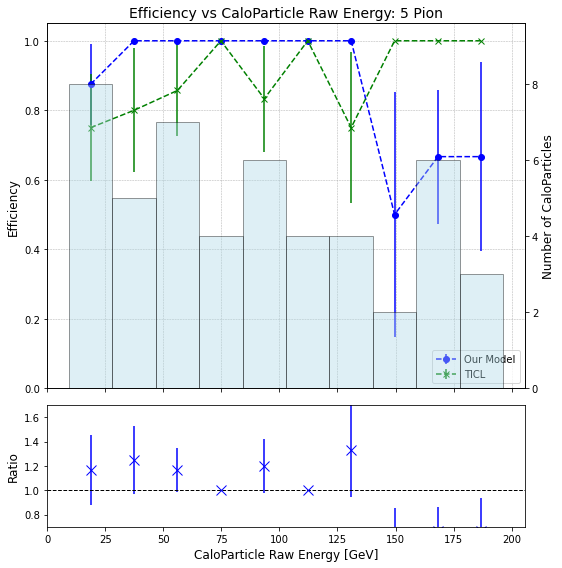

In [25]:
# Assuming df_CL and df_TICL are your two DataFrames
# Replace the following with your actual data loading mechanism
# df_CL = pd.read_csv('df_CL.csv')
# df_TICL = pd.read_csv('df_TICL.csv')

# ----- Preprocessing -----
# Convert relevant columns to numeric.
for df in [df_CL, df_TICL]:
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['shared_energy'] = pd.to_numeric(df['shared_energy'], errors='coerce')  # New Column
    df['cp_raw_energy'] = pd.to_numeric(df['cp_raw_energy'], errors='coerce')

def prepare_cp_data(df):
    """
    Group the DataFrame by ['event_index', 'cp_id'] so that each caloparticle is counted once.
    For each group:
      - Take the first cp_raw_energy (they are identical).
      - Take the maximum shared_energy to check if any shared_energy >= 50% of cp_raw_energy.
      - Mark the caloparticle as 'reconstructed' if any shared_energy >= 50% of cp_raw_energy.
    """
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_raw_energy': 'first',          
        'shared_energy': 'max'        # Use max to determine if any shared_energy meets the threshold
    }).reset_index()
    
    # Mark as reconstructed if any shared_energy >= 50% of cp_raw_energy.
    grouped['reco'] = (grouped['shared_energy'] >= 0.5 * grouped['cp_raw_energy']).astype(int)
    return grouped

# Prepare the caloparticle data for both DataFrames.
df_CL_cp = prepare_cp_data(df_CL)
df_TICL_cp = prepare_cp_data(df_TICL)

# ----- Bin Caloparticles by Energy -----
# Define energy bins based on the range of cp_raw_energy from df_CL.
min_energy = df_CL_cp['cp_raw_energy'].min()
max_energy = df_CL_cp['cp_raw_energy'].max()
n_bins = 10
energy_bins = np.linspace(min_energy, max_energy, n_bins + 1)

# Assign each caloparticle to an energy bin.
df_CL_cp['energy_bin'] = pd.cut(df_CL_cp['cp_raw_energy'], bins=energy_bins, labels=False, include_lowest=True)
df_TICL_cp['energy_bin'] = pd.cut(df_TICL_cp['cp_raw_energy'], bins=energy_bins, labels=False, include_lowest=True)

# ----- Calculate Efficiency per Energy Bin -----
def aggregate_efficiency(df):
    """
    For each energy bin, calculate:
      - The total number of caloparticles in the bin.
      - The number of reconstructed caloparticles.
      - Efficiency = (number of reconstructed) / (total number).
    """
    agg = df.groupby('energy_bin').agg(
        total_cp=('cp_raw_energy', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    
    agg['eff_error'] = np.sqrt(agg['efficiency'] * (1 - agg['efficiency']) / agg['total_cp'])
    return agg

agg_CL = aggregate_efficiency(df_CL_cp)
agg_TICL = aggregate_efficiency(df_TICL_cp)

# ----- Plot Efficiency vs Energy with Histogram Overlay -----
# Compute bin centers for plotting: average of adjacent bin edges.
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2
bar_width = energy_bins[1] - energy_bins[0]

eff_ratio = agg_CL['efficiency'] / agg_TICL['efficiency']
eff_ratio_error = eff_ratio * np.sqrt(
    (agg_CL['eff_error'] / agg_CL['efficiency'])**2 + 
    (agg_TICL['eff_error'] / agg_TICL['efficiency'])**2
)


# Create a figure with two y-axes.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)


# Plot Efficiency
ax1.errorbar(bin_centers, agg_CL['efficiency'], yerr=agg_CL['eff_error'], marker='o',linestyle ='--',  color='blue', label='Our Model')
ax1.errorbar(bin_centers, agg_TICL['efficiency'], yerr=agg_TICL['eff_error'],   marker='x', linestyle ='--', color='green', label='TICL')
ax1.set_ylabel('Efficiency', fontsize=12)
ax1.set_ylim(0, 1.05)
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)



# ----- Histogram for Number of CaloParticles -----
ax1_hist = ax1.twinx()  # Create secondary y-axis for histogram
ax1_hist.bar(bin_centers, agg_CL['total_cp'], width=bar_width, color='lightblue', alpha=0.4, edgecolor='black')
ax1_hist.set_ylabel('Number of CaloParticles', fontsize=12)
ax1_hist.set_ylim(0, agg_CL['total_cp'].max() * 1.2)

# ----- Ratio Plot -----
ax2.errorbar(bin_centers, eff_ratio, yerr=eff_ratio_error, fmt='x', color='blue', markersize=10)
ax2.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('CaloParticle Raw Energy [GeV]', fontsize=12)
ax2.set_ylabel('Ratio', fontsize=12)
ax2.set_ylim(0.7, 1.7)

# Update Title to Reflect New Efficiency Definition
plt.title(r'Efficiency vs CaloParticle Raw Energy: 5 Pion', fontsize=14)
plt.tight_layout()
plt.savefig("plots/efficiency.png")
plt.show()

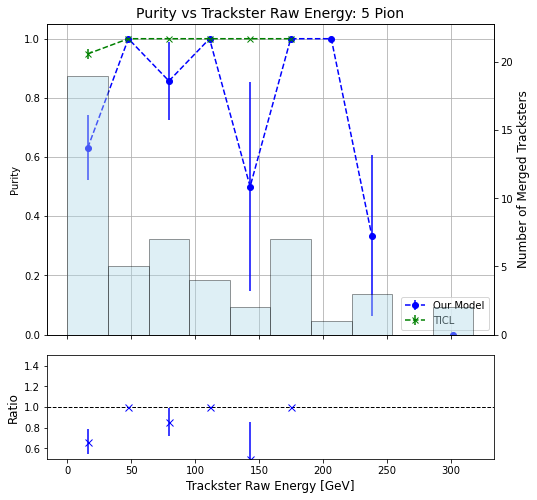

In [100]:
# Convert relevant columns to numeric.
for df in [df_CL, df_TICL]:
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['trackster_energy'] = pd.to_numeric(df['trackster_energy'], errors='coerce')

# -----------------------------
# Prepare Trackster-Level Data for Purity
# -----------------------------
def prepare_trackster_data(df):
    """
    Group the DataFrame by ['event_index', 'trackster_id'] so that each trackster is counted once.
    For each group:
      - Take the first trackster_energy,
      - Take the minimum reco_to_sim_score,
      - Mark the trackster as 'associated' if the minimum reco_to_sim_score is < 0.2.
    """
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'trackster_energy': 'first',       # Use the first trackster_energy value.
        'reco_to_sim_score': 'min'           # Minimum score among the rows for that trackster.
    }).reset_index()
    
    # Mark as associated if reco_to_sim_score is < 0.2.
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

# Prepare the trackster-level data for both DataFrames.
df_CL_ts = prepare_trackster_data(df_CL)
df_TICL_ts   = prepare_trackster_data(df_TICL)

# -----------------------------
# Bin Tracksters by Energy
# -----------------------------
# Define energy bins based on the range of trackster_energy from df_CL.
min_energy_ts = df_CL_ts['trackster_energy'].min()
max_energy_ts = df_CL_ts['trackster_energy'].max()
n_bins_ts = 10  # Adjust the number of bins if desired.
energy_bins_ts = np.linspace(min_energy_ts, max_energy_ts, n_bins_ts + 1)

# Assign each trackster to an energy bin.
df_CL_ts['energy_bin'] = pd.cut(df_CL_ts['trackster_energy'],
                                    bins=energy_bins_ts, labels=False, include_lowest=True)
df_TICL_ts['energy_bin']   = pd.cut(df_TICL_ts['trackster_energy'],
                                    bins=energy_bins_ts, labels=False, include_lowest=True)

# -----------------------------
# Calculate Purity per Energy Bin
# -----------------------------
def aggregate_purity(df):
    """
    For each energy bin, calculate:
      - Total number of tracksters,
      - Number of associated tracksters (with reco_to_sim_score < 0.2),
      - Purity = (number of associated tracksters) / (total number).
    """
    agg = df.groupby('energy_bin').agg(
        total_ts = ('trackster_energy', 'count'),
        assoc_ts = ('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    return agg

agg_CL_ts = aggregate_purity(df_CL_ts)
agg_TICL_ts   = aggregate_purity(df_TICL_ts)

# Reindex both aggregated DataFrames so that they have one row per energy bin (0 to n_bins_ts-1)
agg_CL_ts = agg_CL_ts.set_index('energy_bin').reindex(range(n_bins_ts), fill_value=np.nan).reset_index()
agg_TICL_ts   = agg_TICL_ts.set_index('energy_bin').reindex(range(n_bins_ts), fill_value=np.nan).reset_index()

# -----------------------------
# Plot Purity vs Trackster Energy with Histogram Overlay
# -----------------------------
# Compute bin centers for plotting: average of adjacent bin edges.
bin_centers_ts = (energy_bins_ts[:-1] + energy_bins_ts[1:]) / 2
bar_width_ts = energy_bins_ts[1] - energy_bins_ts[0]

purity_ratio = agg_CL_ts['purity'] / agg_TICL_ts['purity']
purity_ratio_error = purity_ratio * np.sqrt(
    (agg_CL_ts['purity_error'] / agg_CL_ts['purity'])**2 +
    (agg_TICL_ts['purity_error'] / agg_TICL_ts['purity'])**2
)

# Create a figure with two y-axes.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

plt.subplots_adjust(hspace=0.1)  # Set spacing to zero

# Plot purity curves on the primary y-axis.
ax1.errorbar(bin_centers_ts, agg_CL_ts['purity'], yerr=agg_CL_ts['purity_error'], marker='o', linestyle='--', color = 'blue', label='Our Model')
ax1.errorbar(bin_centers_ts, agg_TICL_ts['purity'], yerr = agg_TICL_ts['purity_error'], marker='x', linestyle='--', color = 'green', label='TICL')
ax1.set_ylabel('Purity')
ax1.set_ylim(0, 1.05)
ax1.legend(loc='lower right')
ax1.grid(True)

# Plot histogram (trackster count per energy bin) on the secondary y-axis.
ax1_hist = ax1.twinx()  # Create secondary y-axis for histogram
ax1_hist.bar(bin_centers_ts, agg_CL_ts['total_ts'], width=bar_width_ts, color='lightblue', alpha=0.4, edgecolor='black')
ax1_hist.set_ylabel('Number of Merged Tracksters', fontsize=12)
ax1_hist.set_ylim(0, agg_CL_ts['total_ts'].max() * 1.2)

ax2.errorbar(bin_centers_ts, purity_ratio, yerr=purity_ratio_error, fmt='x', color='blue', markersize=7)
ax2.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Trackster Raw Energy [GeV]', fontsize=12)
ax2.set_ylabel('Ratio', fontsize=12)
ax2.set_ylim(0.5, 1.5)

plt.title(r'Purity vs Trackster Raw Energy: 5 Pion', fontsize=14)
plt.savefig("plots/purity.png")
plt.show()

## Section 3: Response and Resolution plots

* #### Step 1: association
For each caloparticle take the best associated trackster (i.e. the trackster that the caloparticle shares most of its raw energy with). They form a caloparticle-trackster pair.

* #### Step 2: energy ratio histogram
Fill energy ratio histogram of all best tracksters, where energy ratio is defined as:

$$ \text{energy ratio} = \frac{E_{\text{reconstructed}}}{E_{\text{true}}} = \frac{E_{\text{trackster raw energy}}}{E_{\text{caloparticle regressed energy}}}$$  

where the caloparticle regressed energy is calculated for the caloparticle the trackster forms a pair with.

* #### Step 3: calibration
Scale histogram to have a mean at 1 to account for the algorithms only reconstructing the particle shower partially (only parts of the shower with LCs that have noh > 1). 

* #### Step 4: compute response and resolution

$$ \text{resolution} = \text{smallest width of the energy ratio distribution that contains 68.3% (one $\sigma$) of the total area under the curve}  \: / \sqrt{2}$$
$$ \text{response} = \text{central value of the interval that defines the resolution} = 1 \: \text{by construction}$$

TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

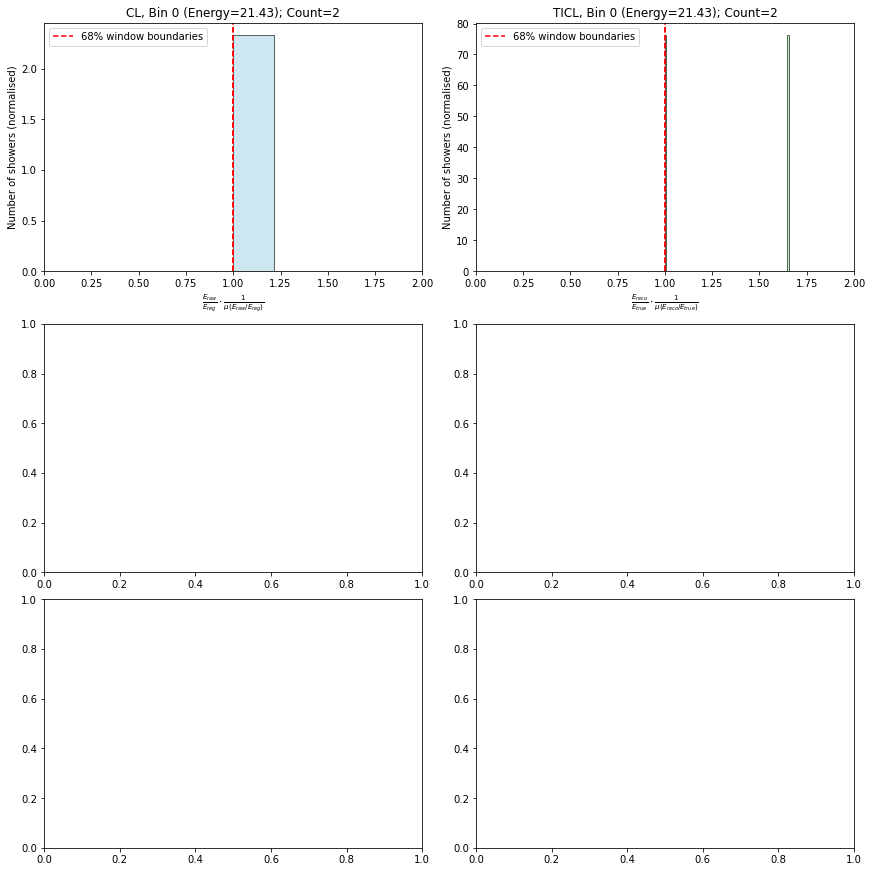

In [25]:
# ====================================================
# 1. Select Best RecoTrackster (Best Associated Trackster) per SimTrackster
# ====================================================
def select_best_trackster(df):
    """
    For each (event_index, cp_id) combination, select the row with the maximum shared_energy.
    This is assumed to give the best associated RecoTrackster for each SimTrackster.
    """
    df = df.copy()
    for col in ['cp_id', 'shared_energy', 'cp_regressed_energy', 'trackster_energy']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    df_best = (df.groupby(['event_index', 'cp_id'], as_index=False)
                 .apply(lambda g: g.loc[g['shared_energy'].idxmax()])
                 .reset_index(drop=True))
    return df_best

# Process both dataframes (df_CL and df_TICL)
df_TICL_best = select_best_trackster(df_TICL)
df_CL_best = select_best_trackster(df_CL)

# ====================================================
# 2. Binning by Caloparticle regressed Energy (to mimic monochromatic samples with frequency)
# ====================================================
n_bins = 30 # no. of monochromatic energies of caloparticles
# Use the energy range from df_CL_assoc as the common binning.
min_energy = df_TICL_best['cp_regressed_energy'].min()
max_energy = df_TICL_best['cp_regressed_energy'].max()
energy_bins = np.linspace(min_energy, max_energy, n_bins + 1)
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2

# Assign each cp to an energy bin.
df_TICL_best['cp_energy_bin'] = pd.cut(df_TICL_best['cp_regressed_energy'],
                                      bins=energy_bins, labels=False, include_lowest=True)
df_CL_best['cp_energy_bin'] = pd.cut(df_CL_best['cp_regressed_energy'],
                                      bins=energy_bins, labels=False, include_lowest=True)

# Assign each cp-tst pair an energy ratio.
df_TICL_best["energy_ratio"] = df_TICL_best["trackster_energy"] / df_TICL_best["cp_regressed_energy"]
df_CL_best["energy_ratio"] = df_CL_best["trackster_energy"] / df_CL_best["cp_regressed_energy"]

# ====================================================
# 3. Compute Sigma Effective in Each Energy Bin
# ====================================================
def compute_sigma_effective_scaled(df, n_bins):
    sigma_eff_vals = []
    sigma_eff_errs = []
    fitted_mean_vals = []
    counts = []
    
    for b in range(n_bins):
        bin_data = df.loc[df['cp_energy_bin'] ==b, 'energy_ratio'].dropna()
        counts.append(len(bin_data))
        
        if len(bin_data) == 0:
            sigma_eff_vals.append(np.nan)
            sigma_eff_errs.append(np.nan)
            fitted_mean_vals.append(np.nan)
            continue
        
        sorted_data = np.sort(bin_data)
        n_points = len(sorted_data)
        
        window_size = int(np.round(0.683 * n_points))
        if window_size < 1:
            window_size = 1
        
        min_width = np.inf
        best_range = (None, None)
        for i in range(n_points - window_size + 1):
            width = sorted_data[i + window_size - 1] - sorted_data[i]
            if width < min_width:
                min_width = width
                best_range = (sorted_data[i], sorted_data[i + window_size - 1])
        
        mu_eff = (best_range[0] + best_range[1]) / 2 
        fitted_mean_vals.append(mu_eff / mu_eff)
        
        sigma_eff = (best_range[1] - best_range[0] ) / np.sqrt(2)
        sigma_eff_err = sigma_eff / np.sqrt(n_points) if n_points > 1 else np.nan
        sigma_eff_vals.append(sigma_eff / mu_eff)
        sigma_eff_errs.append(sigma_eff_err / mu_eff)
        
    return np.array(fitted_mean_vals), np.array(sigma_eff_vals), np.array(sigma_eff_errs), np.array(counts)

fitted_mean_TICL, sigma_eff_TICL, sigma_eff_err_TICL, counts_TICL = compute_sigma_effective_scaled(df_TICL_best, n_bins)
fitted_mean_CL, sigma_eff_CL, sigma_eff_CL, counts_CL = compute_sigma_effective_scaled(df_CL_best, n_bins)

# ====================================================
# 4. Plot Side-by-Side Histograms for Selected Bins (DEBUGGING)
# ====================================================
selected_bins = [0, n_bins // 2, n_bins - 1]
n_sel = len(selected_bins)
fig_hist, axs = plt.subplots(n_sel, 2, figsize=(12, 4 * n_sel), constrained_layout=True)
#xlim_range = (0, 2)  # Fixed x-axis for all histograms

for row, b in enumerate(selected_bins):
    
    # For df_CL histogram:
    data_CL = df_CL_best.loc[df_CL_best['cp_energy_bin'] == b, 'energy_ratio'].dropna()
    ax_left = axs[row, 0] if n_sel > 1 else axs[0, 0]
    
    sorted_data = np.sort(data_CL)
    n_points = len(sorted_data)
    
    window_size = int(np.round(0.683 * n_points))
    if window_size < 1:
        window_size = 1
    min_width = np.inf
    best_range = (None, None)
    for i in range(n_points - window_size + 1):
        width = sorted_data[i + window_size - 1] - sorted_data[i]
        if width < min_width:
            min_width = width
            best_range = (sorted_data[i], sorted_data[i + window_size - 1])
    #sigma_eff_this = best_range[1] - best_range[0]
    mu_eff = (best_range[0] + best_range[1]) / 2

    n_CL, bins_CL, _ = ax_left.hist(sorted_data / mu_eff, bins=100,
                                          color='lightblue', alpha=0.6, edgecolor='k',density=True)
    ax_left.set_xlim(0,2)  
    ax_left.axvline(best_range[0] / mu_eff, color='red', linestyle='--', label='68% window boundaries')
    ax_left.axvline(best_range[1] / mu_eff, color='red', linestyle='--')
    ax_left.set_title(f'CL, Bin {b} (Energy={bin_centers[b]:.2f}); Count={len(data_CL)}')
    ax_left.set_xlabel(r'$\frac{E_{raw}}{E_{reg}} \cdot \frac{1}{\mu(E_{raw}/E_{reg})}$')
    ax_left.set_ylabel('Number of showers (normalised)')
    ax_left.legend(fontsize=10)
    
    # For df_TICL histogram:
    data_TICL = df_TICL_best.loc[df_TICL_best['cp_energy_bin'] == b, 'energy_ratio'].dropna()
    ax_right = axs[row, 1] if n_sel > 1 else axs[0, 1]

    sorted_data = np.sort(data_TICL)
    n_points = len(sorted_data)
    
    window_size = int(np.round(0.683 * n_points))
    if window_size < 1:
        window_size = 1
    min_width = np.inf
    best_range = (None, None)
    for i in range(n_points - window_size + 1):
        width = sorted_data[i + window_size - 1] - sorted_data[i]
        if width < min_width:
            min_width = width
            best_range = (sorted_data[i], sorted_data[i + window_size - 1])
    #sigma_eff_this = best_range[1] - best_range[0]
    mu_eff = (best_range[0] + best_range[1]) / 2

    n_TICL, bins_TICL, _ = ax_right.hist(sorted_data / mu_eff, bins=100,
                                          color='lightgreen', alpha=0.6, edgecolor='k',density=True)
    ax_right.set_xlim(0,2)  
    ax_right.axvline(best_range[0] / mu_eff, color='red', linestyle='--', label='68% window boundaries')
    ax_right.axvline(best_range[1] / mu_eff, color='red', linestyle='--')
    ax_right.set_title(f'TICL, Bin {b} (Energy={bin_centers[b]:.2f}); Count={len(data_TICL)}')
    ax_right.set_xlabel(r'$\frac{E_{reco}}{E_{true}} \cdot \frac{1}{\mu(E_{reco}/E_{true})}$')
    ax_right.set_ylabel('Number of showers (normalised)')
    ax_right.legend(fontsize=10)
    
plt.suptitle('Side-by-Side Histograms of energy_ratio in Selected Trackster Energy Bins', fontsize=14)
plt.show()


# ====================================================
# 5. Plot Response and Resolution vs. cp Energy Bin Centers
# ====================================================

fig_params, (ax_resp, ax_res) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, constrained_layout=True)

ax_resp.plot(bin_centers, fitted_mean_CL, 'bo-', label='Our Model')
ax_resp.plot(bin_centers, fitted_mean_TICL, 'gs-', label='TICL')
ax_resp.axhline(1, color='k', linestyle='--')
ax_resp.set_ylabel(r'$\mu(\frac{E_{reco}}{E_{true}}) / \mu(\frac{E_{reco}}{E_{true}})$', fontsize=15)
ax_resp.set_title('Corrected Response & Resolution vs. Calo Particle Energy')
ax_resp.legend()
ax_resp.grid()

ax_resp2 = ax_resp.twinx()
ax_resp2.bar(bin_centers, counts_CL, width=5, color='lightblue', alpha=0.3)
ax_resp2.set_ylabel('Calo Particles')

ax_res.plot(bin_centers, sigma_eff_CL, 'bo-', label='Our Model')
ax_res.plot(bin_centers, sigma_eff_TICL, 'gs-', label='TICL')
ax_res.set_xlabel('Calo Particle Energy')
ax_res.set_ylabel(r'$\sigma(\frac{E_{reco}}{E_{true}}) / \mu(\frac{E_{reco}}{E_{true}})$', fontsize=15)
ax_res.legend()
ax_res.grid()

ax_res2 = ax_res.twinx()
ax_res2.bar(bin_centers, counts_CL, width=5, color='lightblue', alpha=0.3)
ax_res2.set_ylabel('Calo Particles')

plt.show()

where
* $E_{reco}$ = raw energy of trackster
* $E_{true}$ = regressed energy of caloparticle (that forms a pair with it)
<br>
Note: if we had a truly monochromatic sample then $\sigma(\frac{E_{reco}}{E_{true}}) / \mu(\frac{E_{reco}}{E_{true}})$ would just simplify to $ \frac{\sigma(E_{reco})}{\mu(E_{reco})}$.

## Section 4: Visualisation in detector space

Visualising caloparticle and trackster pairs (i.e. those that share 50% of the raw CP energy) by colouring them similarly. If a trackster shares 50% of a caloparticle's energy for multiple caloparticles, then it is coloured in the same way as the first caloparticle (or caloparticle with lowest index).

######################### Our model ########################


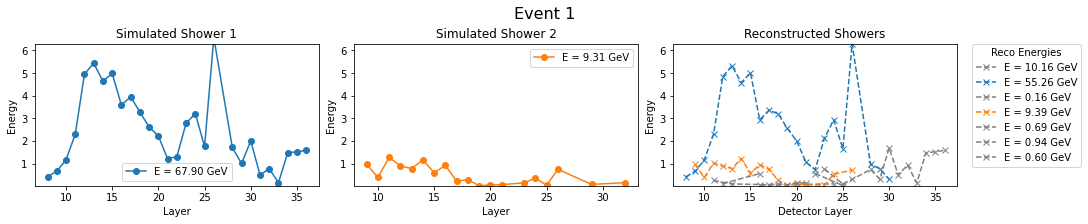

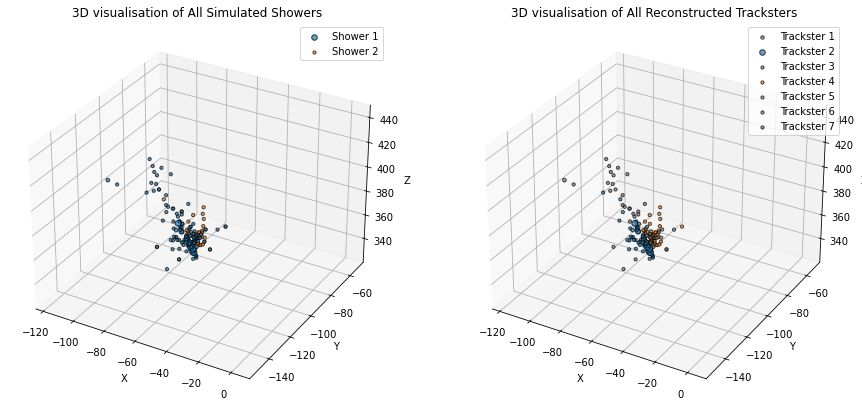

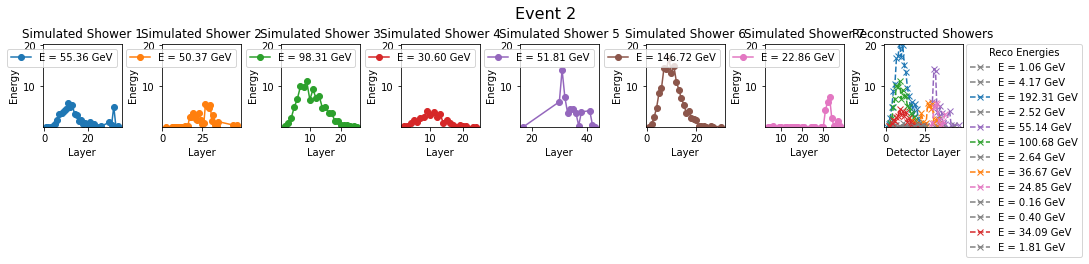

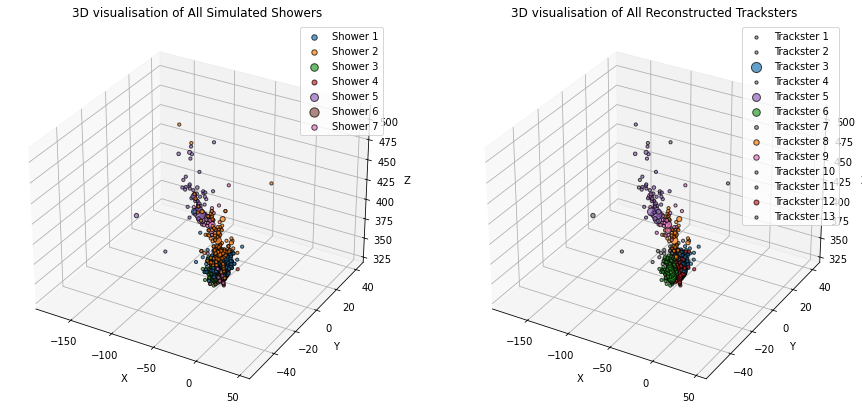

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


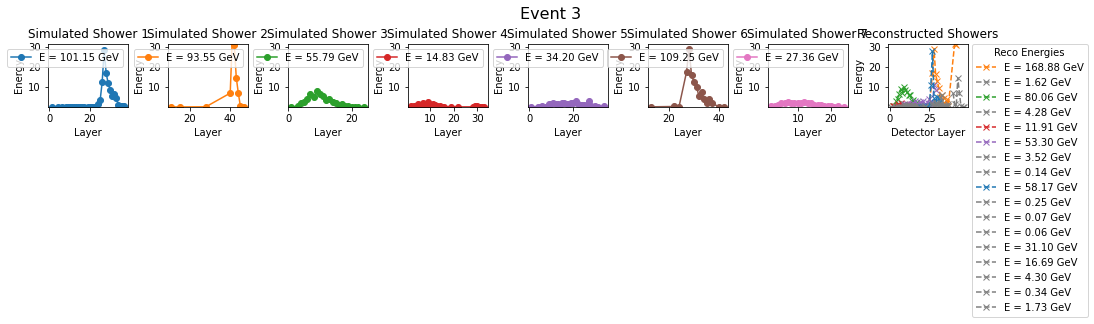

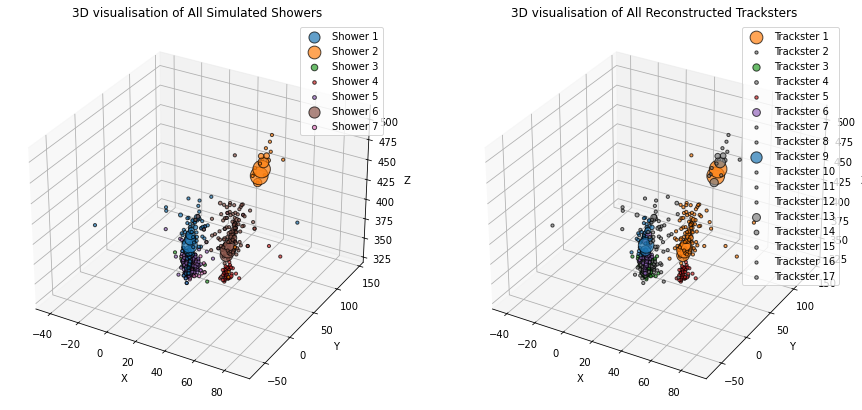

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


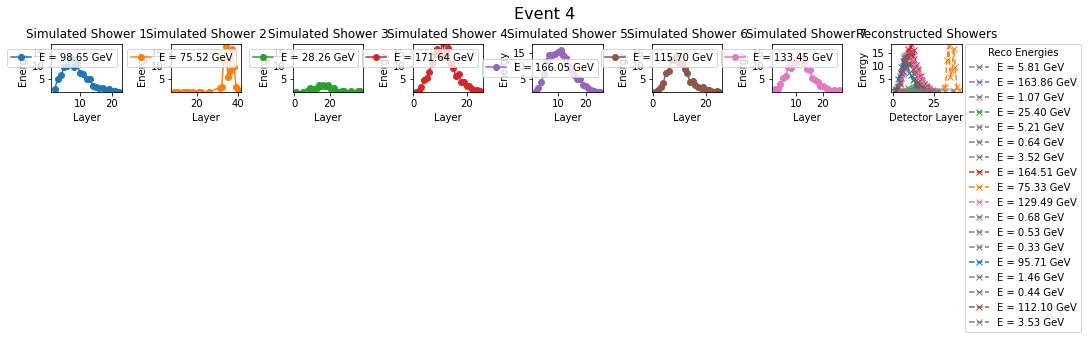

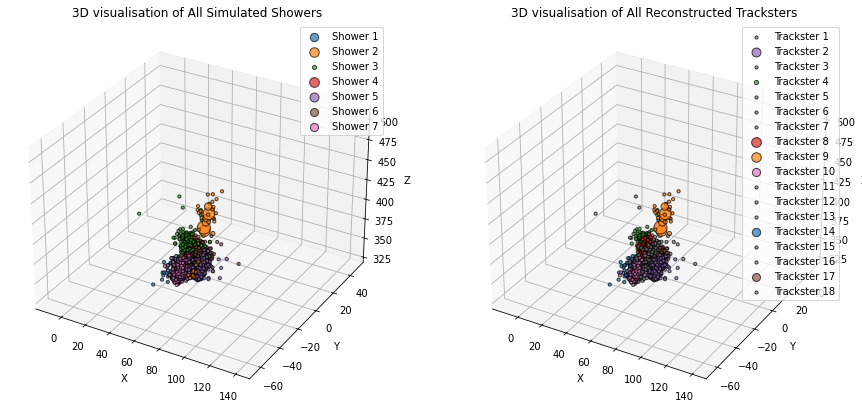

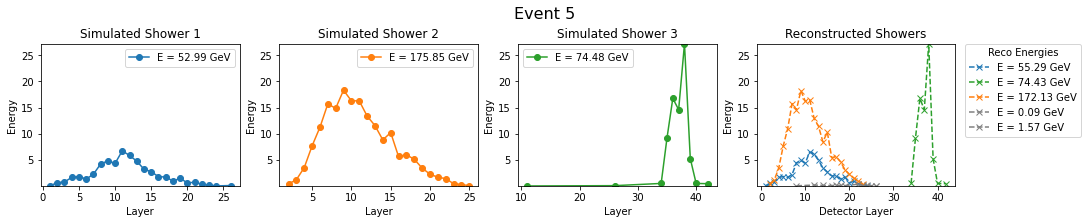

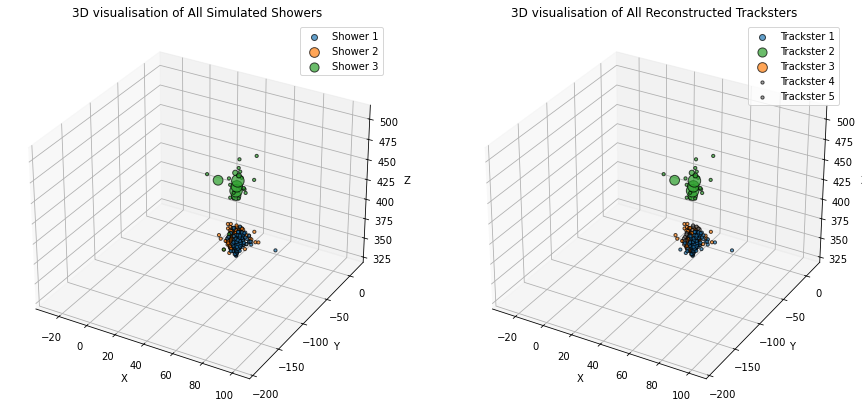

######################### TICL ###########################


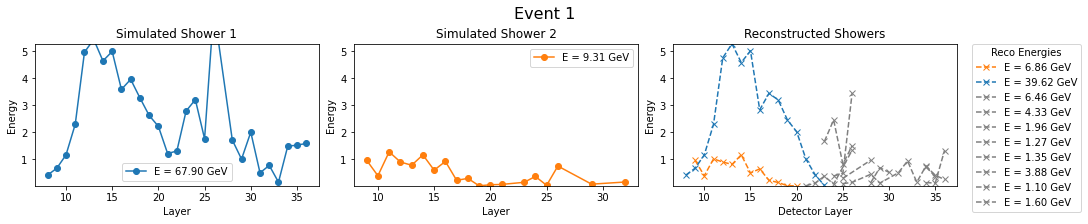

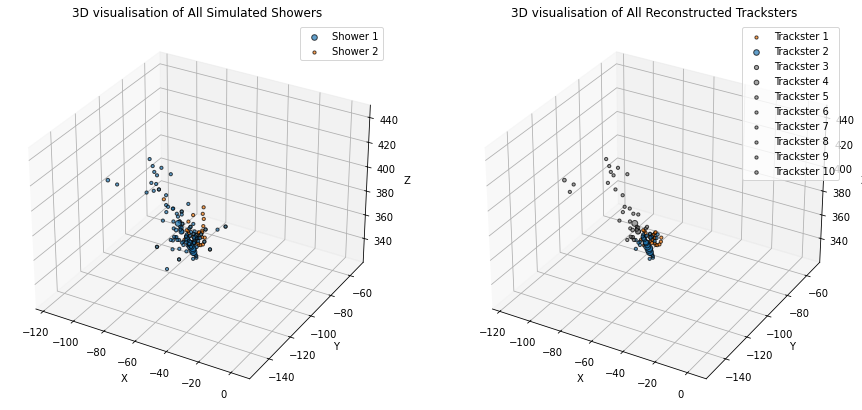

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


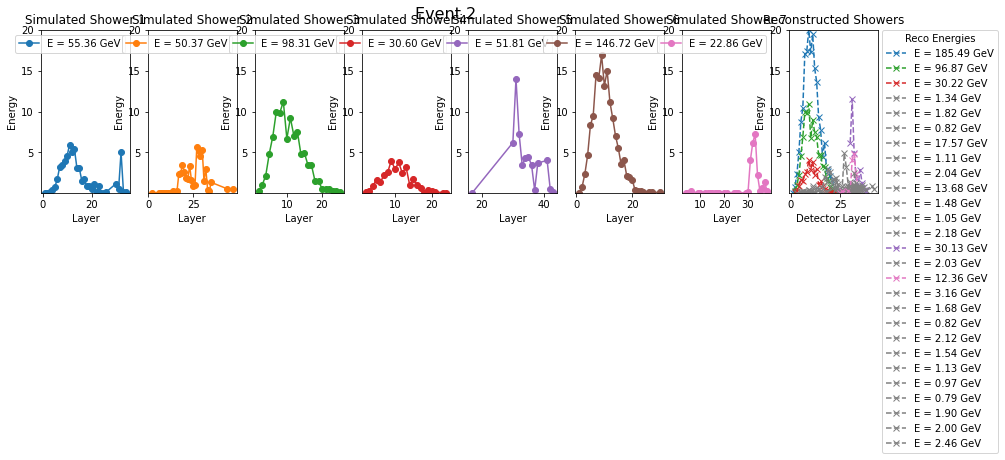

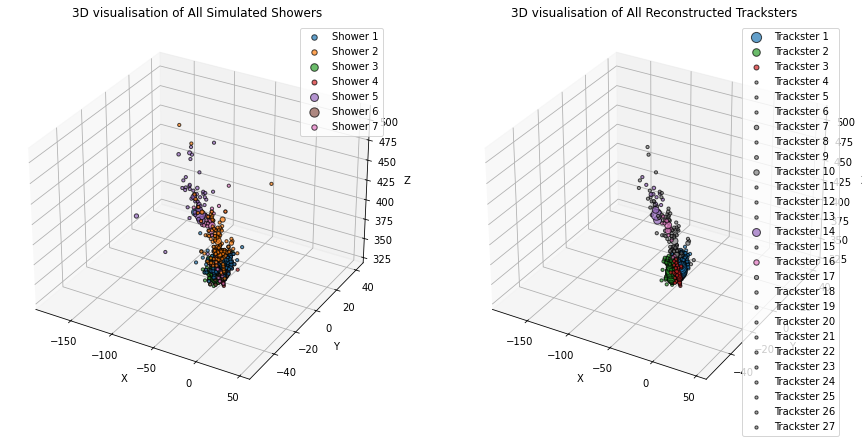

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


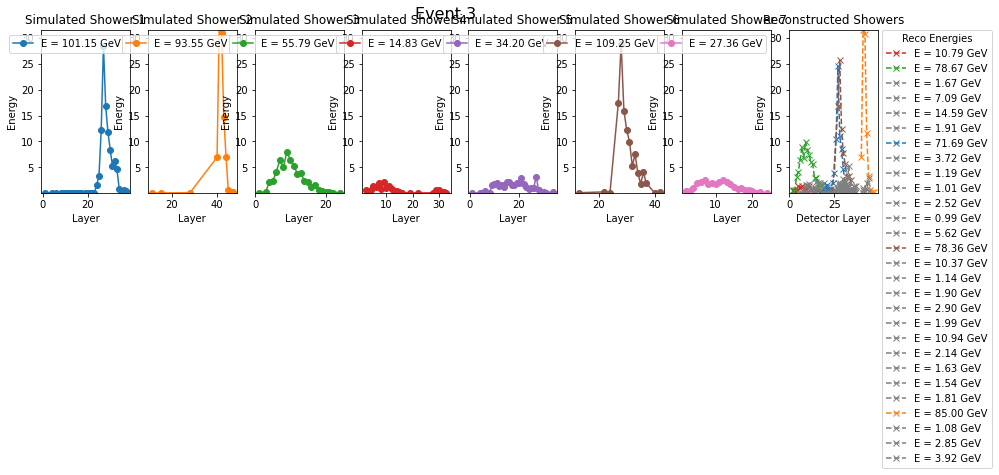

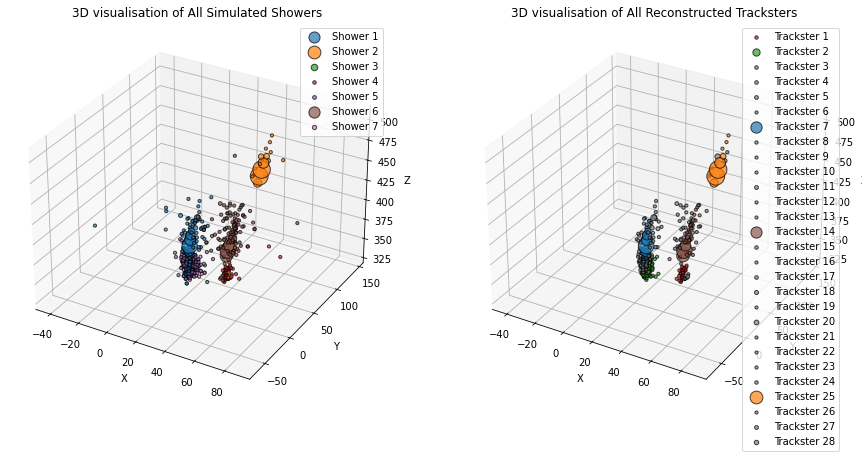

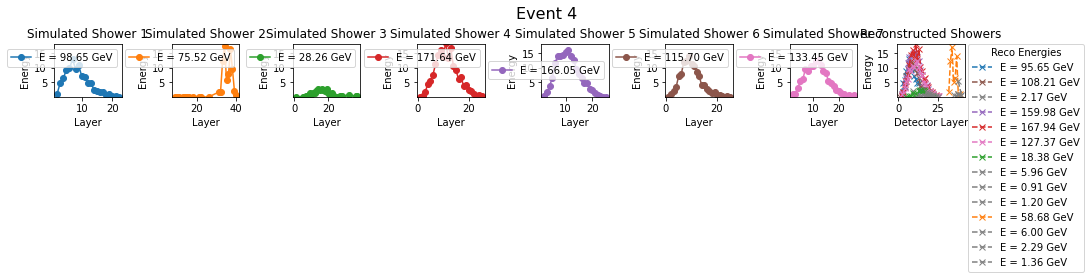

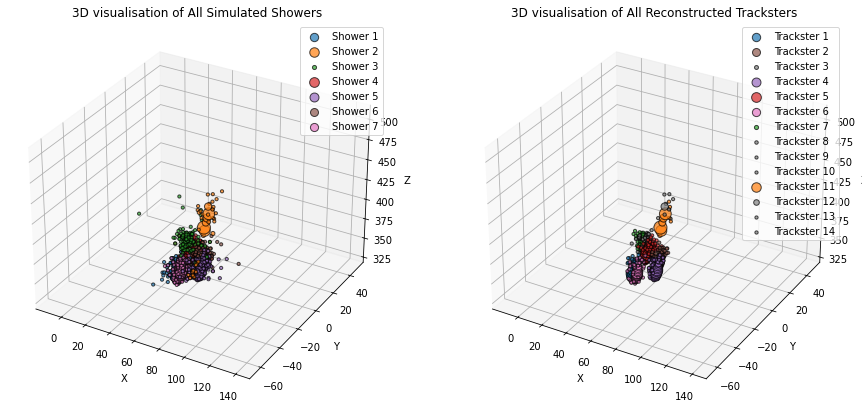

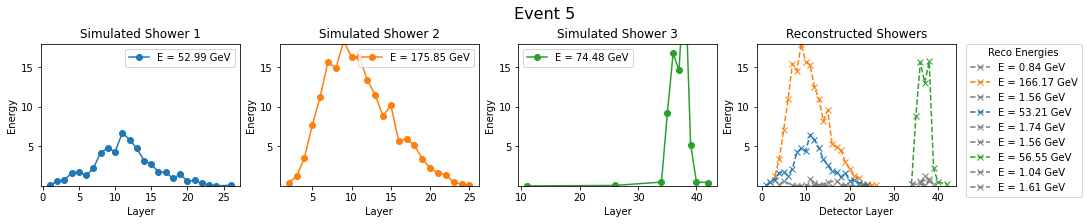

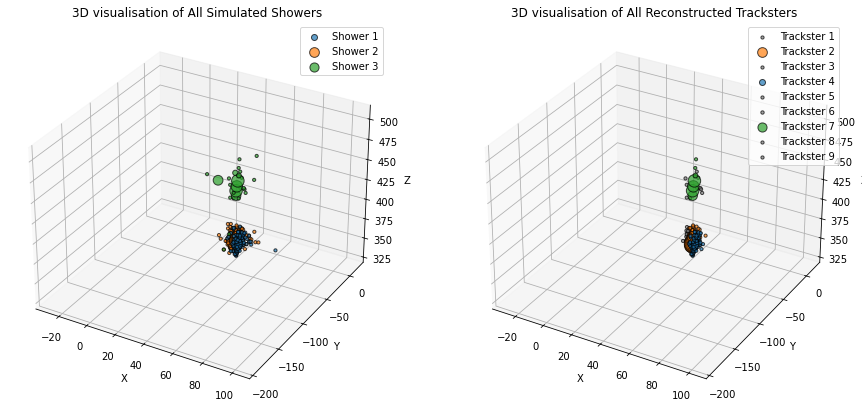

In [26]:
# corrected!!!
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

layerid = data_GT.all_vertices_layer_id
LC_x = data_GT.all_vertices_x
LC_y = data_GT.all_vertices_y
LC_z = data_GT.all_vertices_z

def calculate_all_event_profile_data(GT_ind, GT_mult, energies, layerid, recon_ind, recon_mult, LC_x, LC_y, LC_z, num_events=5):
    colors = list(mcolors.TABLEAU_COLORS.values())
    
    for event_index in range(num_events):
        caloparticles = GT_ind[event_index]
        tracksters = recon_ind[event_index]
        event_energies = energies[event_index]
        event_layer_id = layerid[event_index]
        event_multi = GT_mult[event_index]
        event_multi_tst = recon_mult[event_index]
        event_LC_x = LC_x[event_index]
        event_LC_y = LC_y[event_index]
        event_LC_z = LC_z[event_index]

        simulated_profiles = []
        reconstructed_profiles = []
        associations = {}
        cp_lc_pos_all = []
        cp_lc_energies_all = []
        tst_lc_pos_all = []
        tst_lc_energies_all = []
        total_cp_energies = []
        total_tst_energies = []

        for cp_idx, caloparticle in enumerate(caloparticles):
            cp_lc_layer_id = event_layer_id[caloparticle]
            cp_lc_energies = event_energies[caloparticle] / event_multi[cp_idx]
            df_cp = pd.DataFrame({'energy': cp_lc_energies, 'layer_id': cp_lc_layer_id})
            layer_energy_cp = df_cp.groupby('layer_id')['energy'].sum().reset_index()
            simulated_profiles.append(layer_energy_cp)
            
            cp_lc_pos_all.append([event_LC_x[caloparticle], event_LC_y[caloparticle], event_LC_z[caloparticle]])
            cp_lc_energies_all.append(cp_lc_energies)
            total_cp_energies.append(layer_energy_cp['energy'].sum())

        for trackster in tracksters:
            tst_lc_layer_id = event_layer_id[trackster]
            tst_lc_energies = event_energies[trackster]
            df_tst = pd.DataFrame({'energy': tst_lc_energies, 'layer_id': tst_lc_layer_id})
            layer_energy_tst = df_tst.groupby('layer_id')['energy'].sum().reset_index()
            reconstructed_profiles.append(layer_energy_tst)
            
            tst_lc_pos_all.append([event_LC_x[trackster],event_LC_y[trackster],event_LC_z[trackster]])
            tst_lc_energies_all.append(tst_lc_energies)
            total_tst_energy = sum(tst_lc_energies)
            total_tst_energies.append(layer_energy_tst['energy'].sum())

        for calo_idx, caloparticle in enumerate(caloparticles):
            Calo_multi = event_multi[calo_idx]
            cp_raw_energy = np.sum(event_energies[caloparticle] / Calo_multi)
            best_shared_energy = -1
            best_tst_idx = None
            
            for trackster_idx, trackster in enumerate(tracksters):
                track_mult = event_multi_tst[trackster_idx]
                _, shared_energy = calculate_reco_to_sim_score_and_sharedE(trackster, event_energies, caloparticle, track_mult, Calo_multi)
                if shared_energy >= 0.5 * cp_raw_energy and shared_energy > best_shared_energy:
                    best_shared_energy = shared_energy
                    best_tst_idx = trackster_idx
            
            if best_tst_idx is not None:
                associations[calo_idx] = best_tst_idx
        
        tst_color_map = {tst_idx: 'gray' for tst_idx in range(len(tracksters))}
        for cp_idx, tst_idx in associations.items():
            if tst_color_map[tst_idx] == 'gray':  # Assign color only if it hasn't been assigned yet
                tst_color_map[tst_idx] = colors[cp_idx % len(colors)]
        
        # Determine energy range from reconstructed showers for consistent y-axis
        min_energy = min(profile['energy'].min() for profile in reconstructed_profiles)
        max_energy = max(profile['energy'].max() for profile in reconstructed_profiles)
        
        fig, axes = plt.subplots(1, len(simulated_profiles) + 1, figsize=(15, 3), constrained_layout=True)
        fig.suptitle(f'Event {event_index + 1}', fontsize=16)

        for idx, profile in enumerate(simulated_profiles):
            ax = axes[idx]
            ax.plot(profile['layer_id'], profile['energy'], marker='o', linestyle='-', color=colors[idx % len(colors)], label=f"E = {total_cp_energies[idx]:.2f} GeV")
            ax.set_ylim(min_energy, max_energy)
            ax.set_title(f'Simulated Shower {idx + 1}')
            ax.set_xlabel('Layer')
            ax.set_ylabel('Energy')
            ax.legend()

        ax = axes[-1]
        for idx, profile in enumerate(reconstructed_profiles):
            color = tst_color_map.get(idx, 'gray')
            ax.plot(profile['layer_id'], profile['energy'], marker='x', linestyle='--', color=color, label=f"E = {total_tst_energies[idx]:.2f} GeV")
        
        ax.set_ylim(min_energy, max_energy)
        ax.set_title(f'Reconstructed Showers')
        ax.set_xlabel('Detector Layer')
        ax.set_ylabel('Energy')
        ax.legend(title='Reco Energies', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        
        # Determine global energy scale and axis limits
        all_energies = np.concatenate(cp_lc_energies_all + tst_lc_energies_all)
        min_energy, max_energy = np.min(all_energies), np.max(all_energies)
        x_lim = [min(event_LC_x), max(event_LC_x)]
        y_lim = [min(event_LC_y), max(event_LC_y)]
        z_lim = [min(event_LC_z), max(event_LC_z)]
        
        # 3D Scatter Plot for All Simulated Layer Clusters
        fig = plt.figure(figsize=(15, 7))
        ax_3d = fig.add_subplot(1,2,1, projection='3d')
        for idx, (pos, energies_) in enumerate(zip(cp_lc_pos_all, cp_lc_energies_all)):
            x, y, z = pos
            marker_sizes = np.clip(energies_ * 10, 10, 500)
            ax_3d.scatter(x, y, z, c=colors[idx % len(colors)], alpha=0.7, s=marker_sizes, edgecolors='k', label=f'Shower {idx+1}')
        
        ax_3d.set_xlim(x_lim)
        ax_3d.set_ylim(y_lim)
        ax_3d.set_zlim(z_lim)
        ax_3d.set_title(f'3D visualisation of All Simulated Showers')
        ax_3d.set_xlabel('X')
        ax_3d.set_ylabel('Y')
        ax_3d.set_zlabel('Z')
        ax_3d.legend()
        
        # 3D Scatter Plot for All Reconstructed Tracksters
        ax_3d_reco = fig.add_subplot(1,2,2, projection='3d')
        for idx, (pos, energies_) in enumerate(zip(tst_lc_pos_all, tst_lc_energies_all)):
            x, y, z = pos
            marker_sizes = np.clip(energies_ * 10, 10, 500)
            color = tst_color_map.get(idx, 'gray')
            ax_3d_reco.scatter(x, y, z, c=color, alpha=0.7, s=marker_sizes, edgecolors='k', label=f'Trackster {idx+1}')
        
        ax_3d_reco.set_xlim(x_lim)
        ax_3d_reco.set_ylim(y_lim)
        ax_3d_reco.set_zlim(z_lim)
        ax_3d_reco.set_title(f'3D visualisation of All Reconstructed Tracksters')
        ax_3d_reco.set_xlabel('X')
        ax_3d_reco.set_ylabel('Y')
        ax_3d_reco.set_zlabel('Z')
        ax_3d_reco.legend()
        plt.show()     

print("######################### Our model ########################")
events_CL = calculate_all_event_profile_data(GT_ind, GT_mult, energies, layerid, recon_ind, recon_mult, LC_x, LC_y, LC_z)
print("######################### TICL ###########################")
events_TICL = calculate_all_event_profile_data(GT_ind, GT_mult, energies, layerid, Track_ind, Track_mult, LC_x, LC_y, LC_z)

Key points:
* TICL is still suffering in efficiency and purity metrics as a result of an additional, unknown filtering step performed in the TICL algorithm, which means we are measuring its reconstruction quality against something that TICL never intended to reconstruct (or even able to as it doesn't take input these LCs that are filtered out).
* We are currently penalising both TICL and our model for not being able to do fractional assignments where a caloparticle might only contribute a fraction of energy to a LC. This seemed like the fairest thing to do given we don't know exactly how TICL removes their repeats. Again, it's unfair to judge the TICL algorithm against something they didn't intend the algorithm to do.

# More plots

#### CP2TST

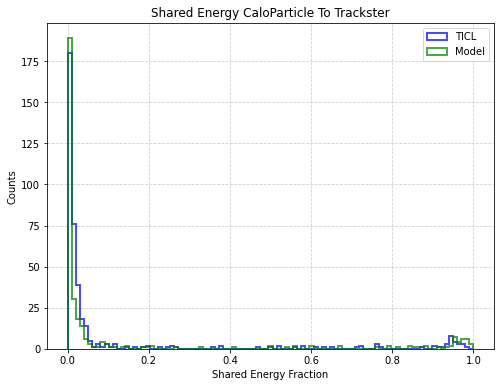

In [27]:
# Assign each cp-tst combination a shared energy fraction
df_TICL["shared_energy_frac"] = df_TICL["shared_energy"] / df_TICL["cp_raw_energy"]
df_CL["shared_energy_frac"] = df_CL["shared_energy"] / df_CL["cp_raw_energy"]

# Remove entries where shared energy is 0
df_TICL_filtered = df_TICL[df_TICL["shared_energy"] > 0].copy()
df_CL_filtered = df_CL[df_CL["shared_energy"] > 0].copy()

# Define bin edges for histogram
bins = np.linspace(0, 1, 100)  # 50 bins between 0 and 1

plt.figure(figsize=(8, 6))

# Plot histograms
plt.hist(df_TICL_filtered["shared_energy_frac"], bins=bins, color='blue', alpha=0.7, label="TICL", histtype='step', linewidth=2)
plt.hist(df_CL_filtered["shared_energy_frac"], bins=bins, color='green', alpha=0.7, label="Model", histtype='step', linewidth=2)

# Labels and titl
plt.xlabel("Shared Energy Fraction")
plt.ylabel("Counts")
plt.title("Shared Energy CaloParticle To Trackster")
plt.legend()

# Show grid
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()

In [28]:
# Define bins
x_bins = np.linspace(0, 1, 100)  # Bins for sim_to_reco_score (X-axis)
y_bins = np.linspace(0, 1, 100)  # Bins for shared_energy_frac (Y-axis)

# Function to plot a 2D histogram
def plot_2d_hist(df, title, cmap):
    plt.figure(figsize=(8, 6))
    hist = plt.hist2d(
        df["sim_to_reco_score"],
        df["shared_energy_frac"],
        bins=[x_bins, y_bins],
        cmap=cmap
    )
    plt.colorbar(label="Counts")
    plt.xlabel("Sim to Reco Score")
    plt.ylabel("Shared Energy Fraction")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# Plot TICL
plot_2d_hist(df_TICL, "TICL: Energy vs Score", cmap="Blues")

# Plot CL
plot_2d_hist(df_CL, "Model: Energy vs Score", cmap="Greens")

KeyError: 'sim_to_reco_score'

<Figure size 576x432 with 0 Axes>

#### TST2CP

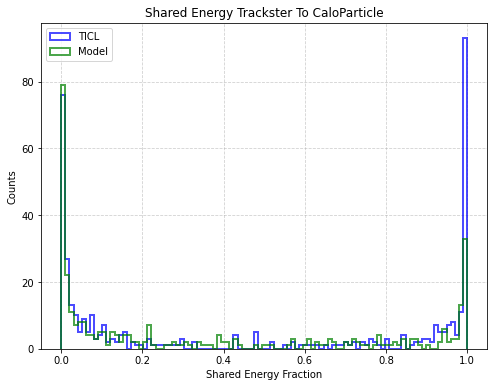

In [29]:
# Assign each cp-tst combination a shared energy fraction
df_TICL["shared_energy_frac_tst"] = df_TICL["shared_energy"] / df_TICL["trackster_energy"]
df_CL["shared_energy_frac_tst"] = df_CL["shared_energy"] / df_CL["trackster_energy"]

# Remove entries where shared energy is 0
df_TICL_filtered = df_TICL[df_TICL["shared_energy"] > 0].copy()
df_CL_filtered = df_CL[df_CL["shared_energy"] > 0].copy()

# Define bin edges for histogram
bins = np.linspace(0, 1, 100)  # 50 bins between 0 and 1

plt.figure(figsize=(8, 6))

# Plot histograms
plt.hist(df_TICL_filtered["shared_energy_frac_tst"], bins=bins, color='blue', alpha=0.7, label="TICL", histtype='step', linewidth=2)
plt.hist(df_CL_filtered["shared_energy_frac_tst"], bins=bins, color='green', alpha=0.7, label="Model", histtype='step', linewidth=2)

# Labels and title
plt.xlabel("Shared Energy Fraction")
plt.ylabel("Counts")
plt.title("Shared Energy Trackster To CaloParticle")
plt.legend()

# Show grid
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()

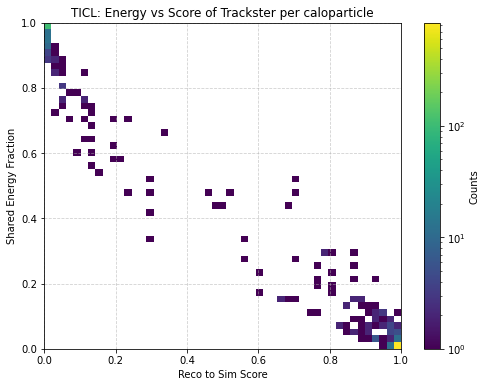

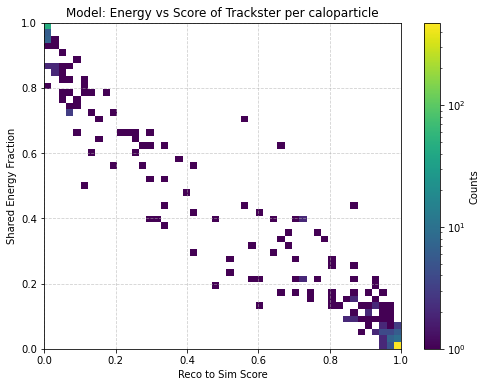

In [30]:
# Define bins (reduce the number for better visibility)
x_bins = np.linspace(0, 1, 50)  # X-axis bins
y_bins = np.linspace(0, 1, 50)  # Y-axis bins

# Function to plot a 2D histogram with a blue-green-yellow colormap
def plot_2d_hist(df, title):
    df_filtered = df.dropna(subset=["reco_to_sim_score", "shared_energy_frac_tst"]).copy()

    plt.figure(figsize=(8, 6))
    hist = plt.hist2d(
        df_filtered["reco_to_sim_score"],
        df_filtered["shared_energy_frac_tst"],
        bins=[x_bins, y_bins],
        cmap="viridis",  # Alternative: "cividis" (less contrast but good visibility)
        norm=mcolors.LogNorm(),  # Log scale for better contrast
        cmin=1  # Only show bins with at least 1 count
    )
    plt.colorbar(label="Counts")
    plt.xlabel("Reco to Sim Score")
    plt.ylabel("Shared Energy Fraction")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# Plot TICL
plot_2d_hist(df_TICL, "TICL: Energy vs Score of Trackster per caloparticle")

# Plot CL
plot_2d_hist(df_CL, "Model: Energy vs Score of Trackster per caloparticle")


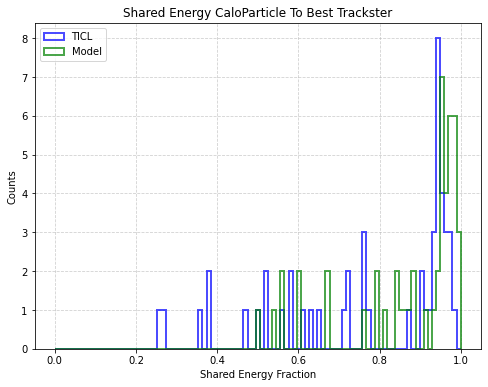

In [31]:
df_TICL_best = select_best_trackster(df_TICL)
df_CL_best = select_best_trackster(df_CL)

# Define bin edges for histogram
bins = np.linspace(0, 1, 100)  # 50 bins between 0 and 1

plt.figure(figsize=(8, 6))

# Plot histograms
plt.hist(df_TICL_best["shared_energy_frac"], bins=bins, color='blue', alpha=0.7, label="TICL", histtype='step', linewidth=2)
plt.hist(df_CL_best["shared_energy_frac"], bins=bins, color='green', alpha=0.7, label="Model", histtype='step', linewidth=2)

# Labels and title
plt.xlabel("Shared Energy Fraction")
plt.ylabel("Counts")
plt.title("Shared Energy CaloParticle To Best Trackster")
plt.legend()

# Show grid
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()

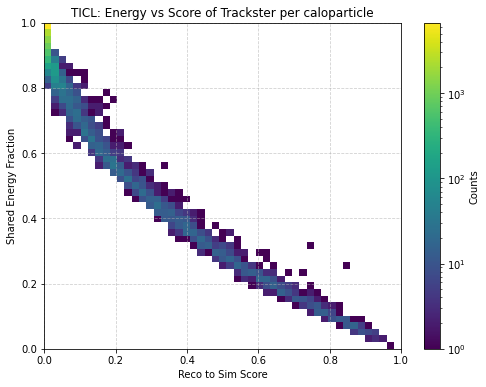

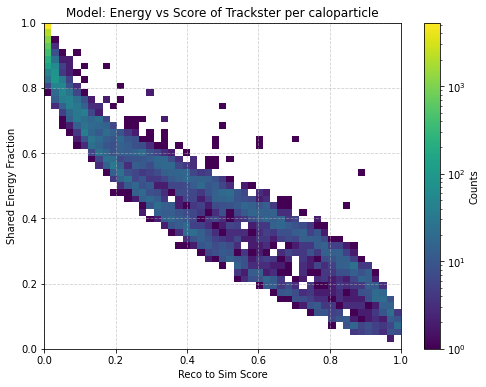

In [49]:
# best trackster needs to be that which has the lowest reco_to_sim score not the greatest shared_energy!!!!!!!!!!!!!
# Define bins (reduce the number for better visibility)
x_bins = np.linspace(0, 1, 50)  # X-axis bins
y_bins = np.linspace(0, 1, 50)  # Y-axis bins

# Function to plot a 2D histogram with a blue-green-yellow colormap
def plot_2d_hist(df, title):
    df_filtered = df.dropna(subset=["reco_to_sim_score", "shared_energy_frac_tst"]).copy()

    plt.figure(figsize=(8, 6))
    hist = plt.hist2d(
        df_filtered["reco_to_sim_score"],
        df_filtered["shared_energy_frac_tst"],
        bins=[x_bins, y_bins],
        cmap="viridis",  # Alternative: "cividis" (less contrast but good visibility)
        norm=mcolors.LogNorm(),  # Log scale for better contrast
        cmin=1  # Only show bins with at least 1 count
    )
    plt.colorbar(label="Counts")
    plt.xlabel("Reco to Sim Score")
    plt.ylabel("Shared Energy Fraction")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# Plot TICL
plot_2d_hist(df_TICL_best, "TICL: Energy vs Score of Best Trackster per caloparticle")

# Plot CL
plot_2d_hist(df_CL_best, "Model: Energy vs Score of Best Trackster per caloparticle")